In [25]:
import os
import itertools
from collections import Counter
import warnings
warnings.filterwarnings("ignore", message=".*set_ticklabels.*")


from tqdm import tqdm

import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR

from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.pipeline import FeatureUnion

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../')
from utils import mixup, write_pickled_object, cohen_d
from utils import get_stats as get_stats_best
from utils import FeatureSelector, MeanCenterer, ModalitySelector

In [26]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [27]:
res = pd.read_csv(os.path.join(data_path, 'interim', 
                               'pipeline_model_selection_joint_individual.csv'), index_col = 0)
model_types = ['Ridge', 'ElasticNet', 'Lasso', 'PLS', 'SVR_linear',
               'SVR_poly', 'SVR_rbf', 'KNN', 'RFR']
res.model_type = pd.Categorical(res.model_type, categories = model_types, ordered = True)

Let's take a look at the results from the model selection:

In [4]:
# sort by mean correlation
ordered_corr = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_corr', ascending=False)
corr_order = ordered_corr.index.tolist()
ordered_corr


/tmp/ipykernel_832918/1884020405.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordered_corr = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_corr', ascending=False)


,test_corr,test_mse
model_type,,
SVR_poly,0.492200,2.369100
SVR_rbf,0.491808,2.330026
Ridge,0.487893,2.402252
SVR_linear,0.480137,2.381690
RFR,0.420922,2.542261
KNN,0.417595,2.487431
PLS,0.407850,2.603205
ElasticNet,0.327165,2.694718
Lasso,0.271396,2.849585


In [5]:
# sort by median correlation
res.groupby('model_type')[['test_corr', 'test_mse']].median().sort_values(by = 'test_corr', ascending=False)

/tmp/ipykernel_832918/2570664844.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('model_type')[['test_corr', 'test_mse']].median().sort_values(by = 'test_corr', ascending=False)


,test_corr,test_mse
model_type,,
Ridge,0.516970,2.258206
SVR_poly,0.497546,2.211130
SVR_linear,0.493624,2.274620
SVR_rbf,0.486885,2.129550
RFR,0.411633,2.445342
PLS,0.372446,2.592113
KNN,0.355949,2.382026
ElasticNet,0.324112,2.521854
Lasso,0.240582,2.769855


In [6]:
# sort by correlation variance
res.groupby('model_type').test_corr.var().sort_values(ascending = True)

/tmp/ipykernel_832918/1169242599.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('model_type').test_corr.var().sort_values(ascending = True)


model_type
ElasticNet    0.010293
RFR           0.011539
SVR_linear    0.017234
SVR_rbf       0.019600
KNN           0.021084
PLS           0.021351
SVR_poly      0.022019
Ridge         0.023199
Lasso         0.032194
Name: test_corr, dtype: float64

In [7]:
# sort by mean MSE
ordered_mse = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_mse', ascending=True)
mse_order = ordered_mse.index.tolist()
ordered_mse

/tmp/ipykernel_832918/2640724910.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ordered_mse = res.groupby('model_type')[['test_corr', 'test_mse']].mean().sort_values(by = 'test_mse', ascending=True)


,test_corr,test_mse
model_type,,
SVR_rbf,0.491808,2.330026
SVR_poly,0.492200,2.369100
SVR_linear,0.480137,2.381690
Ridge,0.487893,2.402252
KNN,0.417595,2.487431
RFR,0.420922,2.542261
PLS,0.407850,2.603205
ElasticNet,0.327165,2.694718
Lasso,0.271396,2.849585


In [8]:
# sort by median MSE
res.groupby('model_type')[['test_corr', 'test_mse']].median().sort_values(by = 'test_mse', ascending=True)

/tmp/ipykernel_832918/1731851835.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('model_type')[['test_corr', 'test_mse']].median().sort_values(by = 'test_mse', ascending=True)


,test_corr,test_mse
model_type,,
SVR_rbf,0.486885,2.129550
SVR_poly,0.497546,2.211130
Ridge,0.516970,2.258206
SVR_linear,0.493624,2.274620
KNN,0.355949,2.382026
RFR,0.411633,2.445342
ElasticNet,0.324112,2.521854
PLS,0.372446,2.592113
Lasso,0.240582,2.769855


In [9]:
# sort by mse variance
res.groupby('model_type').test_mse.var().sort_values(ascending = True)

/tmp/ipykernel_832918/3230113901.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  res.groupby('model_type').test_mse.var().sort_values(ascending = True)


model_type
RFR           0.262430
KNN           0.327801
ElasticNet    0.344472
PLS           0.349652
SVR_rbf       0.374727
SVR_poly      0.449287
SVR_linear    0.455048
Lasso         0.514334
Ridge         0.577316
Name: test_mse, dtype: float64

Let's compare each models performance with identified best hyperparameters for a specific fold:

In [10]:
res_stats = pd.DataFrame(columns = ['comparison', 'pval_corr', 'cohen_d_corr', 
                                   'pval_mse', 'cohen_d_mse'])
mod_combs = list(itertools.combinations((res.model_type.unique()), 2))

for mc in mod_combs:
    a = res[res.model_type == mc[0]]
    b = res[res.model_type == mc[1]]
    
    pval_corr = stats.mannwhitneyu(a.test_corr,b.test_corr).pvalue
    cd_corr = cohen_d(a.test_corr,b.test_corr)
    
    pval_mse = stats.mannwhitneyu(a.test_mse,b.test_mse).pvalue
    cd_mse = cohen_d(a.test_mse,b.test_mse)
    
    res_stats.loc[res_stats.shape[0], :] = [mc, pval_corr, cd_corr, pval_mse, cd_mse]
    
_, fdr_corr, _, _ = multipletests(res_stats.pval_corr.values, method='fdr_bh')
_, fdr_mse, _, _ = multipletests(res_stats.pval_mse.values, method='fdr_bh')
res_stats['fdr_corr'] = fdr_corr
res_stats['fdr_mse'] = fdr_mse
res_stats

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
0,"(SVR_linear, PLS)",0.273036,0.520437,0.472676,-0.349221,0.481288,0.918972
1,"(SVR_linear, SVR_poly)",0.791337,-0.086106,0.96985,0.018723,0.949604,0.96985
2,"(SVR_linear, SVR_rbf)",0.96985,-0.085996,0.96985,0.080209,0.96985,0.96985
3,"(SVR_linear, RFR)",0.307489,0.493699,0.427355,-0.268088,0.481288,0.918972
4,"(SVR_linear, KNN)",0.307489,0.451843,0.677585,-0.169012,0.481288,0.918972
5,"(SVR_linear, Ridge)",0.623176,-0.054547,0.850107,-0.02862,0.801227,0.95637
6,"(SVR_linear, Lasso)",0.014019,1.327811,0.140465,-0.672072,0.084116,0.918972
7,"(SVR_linear, ElasticNet)",0.005795,1.303906,0.212294,-0.49509,0.084116,0.918972
8,"(PLS, SVR_poly)",0.384673,-0.572808,0.520523,0.370398,0.532624,0.918972
9,"(PLS, SVR_rbf)",0.344704,-0.586737,0.472676,0.453919,0.496374,0.918972


In [11]:
res_stats[res_stats.fdr_corr <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse
6,"(SVR_linear, Lasso)",0.014019,1.327811,0.140465,-0.672072,0.084116,0.918972
7,"(SVR_linear, ElasticNet)",0.005795,1.303906,0.212294,-0.49509,0.084116,0.918972
19,"(SVR_poly, Lasso)",0.021134,1.341132,0.121225,-0.692216,0.095103,0.918972
20,"(SVR_poly, ElasticNet)",0.007285,1.298405,0.241322,-0.516868,0.084116,0.918972
24,"(SVR_rbf, Lasso)",0.014019,1.369648,0.121225,-0.779263,0.084116,0.918972
25,"(SVR_rbf, ElasticNet)",0.007285,1.346697,0.185877,-0.608158,0.084116,0.918972
33,"(Ridge, Lasso)",0.01133,1.300888,0.185877,-0.605486,0.084116,0.918972
34,"(Ridge, ElasticNet)",0.017257,1.24204,0.307489,-0.4308,0.088753,0.918972


In [12]:
res_stats[res_stats.fdr_mse <= 0.1]

,comparison,pval_corr,cohen_d_corr,pval_mse,cohen_d_mse,fdr_corr,fdr_mse


Here, we see that the SVRs and Ridge tend to outperform other models as measured by Pearson correlation.

/tmp/ipykernel_832918/1467105035.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],
/tmp/ipykernel_832918/1467105035.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i],


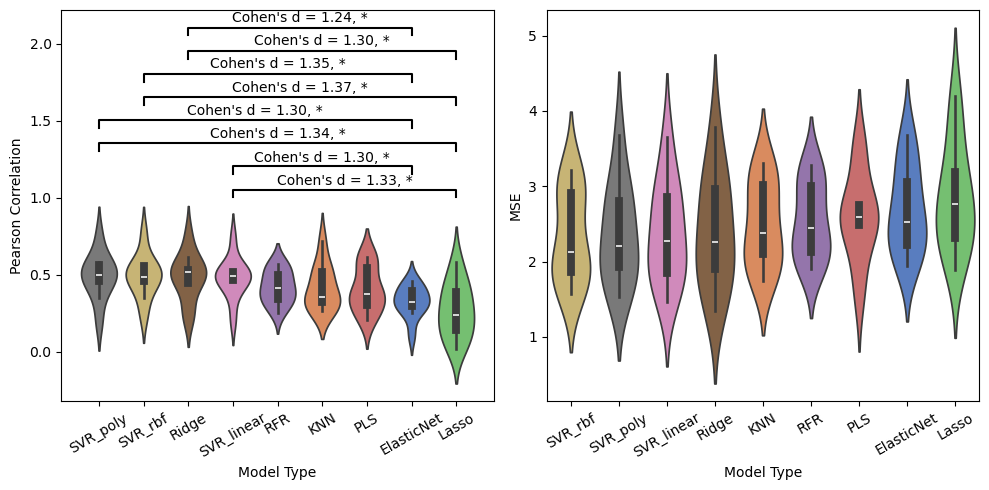

In [13]:
fig, ax = plt.subplots(ncols = 2, figsize = (10,5))

metric_types = ['corr', 'mse']
mmap = dict(zip(metric_types, ['Pearson Correlation', 'MSE']))
order_map = dict(zip(metric_types, [corr_order, mse_order]))

palette = dict(zip(sorted(res.model_type.unique()), sns.color_palette("muted")))

for i, metric_type in enumerate(metric_types):
    # sort by mean of metric
    res.model_type = pd.Categorical(res.model_type, categories = order_map[metric_type], 
                               ordered = True)
    
    
    sns.violinplot(data = res, x = 'model_type', y = 'test_' + metric_type, ax = ax[i], 
                  palette = palette)#,
#                    fill = False, inner = None)
    
#     sns.boxplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                 width=0.1, 
#                 color="black", showcaps=False, boxprops={'facecolor':'none'}, 
#                 whiskerprops={'linewidth':0.5}, ax = ax[i])
#     sns.stripplot(data=res, x = 'model_type', y = 'test_' + metric_type, 
#                   alpha=0.5, jitter=True, dodge=True, ax = ax[i], color = 'black')
    
    ax[i].set_xlabel('Model Type')
    ax[i].set_ylabel(mmap[metric_type])
    
    xlabels = [x._text for x in ax[i].get_xticklabels()]
    x_pos = dict(zip(xlabels, ax[i].get_xticks()))
    y, h = ax[i].get_ylim()[1], 0.05
    
    ax[i].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
    
    sig_counter = 0
    for j, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2
        
        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr_' + metric_type].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d_' + metric_type].values[0]
        
        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"
        
        if significance != 'N.S.':
            y_pos = y+(sig_counter*0.15)
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                       [y_pos, y_pos+h, y_pos+h, y_pos], 
                       lw=1.5, c='black')
            y_pos*=1.01
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1

#     ax[i].grid(axis='y', linestyle='--', alpha=0.7)
    
fig.tight_layout()


For each metric (panels), violin plots are ordered by the best performing mean value across folds. Each fold has the best model selected using optuna hyperparameter tuning. We observe the following: 
- relative model performance is consistent between correlation and MSE, with SVMs performing best (with the exception of Ridge regression).
- there are no significant differences in any of the model performance for MSE. However, for Pearson correlation, SVMs and Ridge outperform ElasticNet and Lasso regression. 


# Consensus model

Here, we simply want to assess consensus joint omics models' predictive performance, particularly relative to transcriptomics.  Thus, we'll take the top two models by each metric, and see how they perform as compared to the consensus model identified for transcriptomics (in [this notebook]( ../A_rna_prediction/03_predict_transcriptomics.ipynb)). Between Pearson correlation and MSE, the top 3 performing models are:
- Ridge
- SVR poly
- SVR linear
- SVR rbf

In [4]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean'].values.ravel()

expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)

protein_cols = expr_protein.columns
rna_cols = expr_rna.columns

with open(os.path.join(data_path, 'processed', 'protein_cols.txt'), 'w') as f:
    for item in protein_cols:
        f.write(item + '\n')
        
with open(os.path.join(data_path, 'processed', 'rna_cols.txt'), 'w') as f:
    for item in rna_cols:
        f.write(item + '\n')

X_protein = X[protein_cols].values
X_rna = X[rna_cols].values

Let's get the consensus model for ridge:

In [5]:
model_type = 'Ridge'
print(model_type)
res_model = res[res.model_type == model_type]

features_best_rna = []
features_best_protein = []
alpha_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    features_best_protein.append(int(bp.split(', ')[0].split(': ')[1]))
    features_best_rna.append(int(bp.split(', ')[1].split(': ')[1]))
    alpha_best.append(float(bp.split(', ')[2].split(': ')[1][:-1]))
    
    
protein_pipeline = Pipeline([
    ("select_protein", ModalitySelector(modality="protein")),
    ("feature_selection_protein", FeatureSelector(method="top_n_cv", n_features=int(np.round(np.median(features_best_protein))))),
    ("mean_centering_protein", MeanCenterer()),  # Mean centering for protein data
])

# RNA-specific pipeline
rna_pipeline = Pipeline([
    ("select_rna", ModalitySelector(modality="rna")),
    ("feature_selection_rna", FeatureSelector(method="top_n_cv", n_features=Counter(features_best_rna).most_common()[0][0])),
    ("mean_centering_rna", MeanCenterer()),  # Mean centering for RNA data
])

# Combine both pipelines
combined_pipeline = FeatureUnion([
    ("protein_pipeline", protein_pipeline),
    ("rna_pipeline", rna_pipeline),
])

best_steps = [
    ("feature_processing", combined_pipeline),
]

best_steps.append(
    ('model', Ridge(alpha=np.mean(alpha_best),
                    random_state=random_state))
)

best_pipeline_ridge = Pipeline(best_steps)
best_pipeline_ridge

Ridge
{'FeatureSelector__n_features_protein': 10968, 'FeatureSelector__n_features_rna': 19138, 'Ridge__alpha': 77.1368278173488}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 250, 'FeatureSelector__n_features_rna': 19138, 'Ridge__alpha': 65.10435341239791}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 1000, 'FeatureSelector__n_features_rna': 19138, 'Ridge__alpha': 85.71937921507747}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 500, 'FeatureSelector__n_features_rna': 19138, 'Ridge__alpha': 75.64157829647934}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 1000, 'FeatureSelector__n_features_rna': 19138, 'Ridge__alpha': 96.8873448663779}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 250, 'FeatureSelector__n_features_rna': 19138, 'Ridge__alpha': 78.1

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('protein_pipeline',
                                                 Pipeline(steps=[('select_protein',
                                                                  ModalitySelector(modality='protein')),
                                                                 ('feature_selection_protein',
                                                                  FeatureSelector(n_features=750)),
                                                                 ('mean_centering_protein',
                                                                  MeanCenterer())])),
                                                ('rna_pipeline',
                                                 Pipeline(steps=[('select_rna',
                                                                  ModalitySelector(modality='rna')),
                                                                 ('feature_selection_rna',
                                                                  FeatureSelector(n_features=19138)),
                                                                 ('mean_centering_rna',
                                                                  MeanCenterer())]))])),
                ('model',
                 Ridge(alpha=np.float64(81.17182160067935), random_state=42))])

For Ridge protein features, since counts were pretty evenly split between 250, 1000, 500, and 10968, instead of choosing the most commonly used feature as we typically do, we take the median (which is 750 features). 

In [6]:
model_type = 'SVR_linear'
print(model_type)

res_model = res[res.model_type == model_type]

features_best_rna = []
features_best_protein = []
C_best = []
epsilon_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    features_best_protein.append(int(bp.split(', ')[0].split(': ')[1]))
    features_best_rna.append(int(bp.split(', ')[1].split(': ')[1]))
    C_best.append(float(bp.split(', ')[2].split(': ')[1]))
    epsilon_best.append(float(bp.split(', ')[3].split(': ')[1][:-1]))
    
protein_pipeline = Pipeline([
    ("select_protein", ModalitySelector(modality="protein")),
    ("feature_selection_protein", FeatureSelector(method="top_n_cv", n_features=Counter(features_best_protein).most_common()[0][0])),
    ("mean_centering_protein", MeanCenterer()),  # Mean centering for protein data
])

# RNA-specific pipeline
rna_pipeline = Pipeline([
    ("select_rna", ModalitySelector(modality="rna")),
    ("feature_selection_rna", FeatureSelector(method="top_n_cv", n_features=Counter(features_best_rna).most_common()[0][0])),
    ("mean_centering_rna", MeanCenterer()),  # Mean centering for RNA data
])

# Combine both pipelines
combined_pipeline = FeatureUnion([
    ("protein_pipeline", protein_pipeline),
    ("rna_pipeline", rna_pipeline),
])

best_steps = [
    ("feature_processing", combined_pipeline),
]
best_steps.append(("model", SVR(
    kernel='linear',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best)
)))
best_pipeline_svr_linear = Pipeline(best_steps)
best_pipeline_svr_linear

write_pickled_object(best_pipeline_svr_linear, 
                    os.path.join(data_path, 'processed', 'best_model_svr_linear_joint.pickle'))

SVR_linear
{'FeatureSelector__n_features_protein': 250, 'FeatureSelector__n_features_rna': 19138, 'SVR_linear__C': 0.00014300636403389178, 'SVR_linear__epsilon': 0.7543617841038908}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 250, 'FeatureSelector__n_features_rna': 19138, 'SVR_linear__C': 0.7704427652405226, 'SVR_linear__epsilon': 0.48216352651446237}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 1000, 'FeatureSelector__n_features_rna': 19138, 'SVR_linear__C': 0.004954258333437953, 'SVR_linear__epsilon': 0.8122417578864235}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 500, 'FeatureSelector__n_features_rna': 19138, 'SVR_linear__C': 0.03890834368131919, 'SVR_linear__epsilon': 0.46392654757098534}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 500, 'FeatureSelector__n_features_rna': 19138, 'SVR

For the linear SVR, the number of protein features is split pretty evenly between 500 (4 folds), 250 (3 folds), and 1000 (3 folds). In this instance, the median is equal to the most commonly selected number of features, so we proceed with 500 features

In the linear SVR mdoel, since the number of features selected is split evenly between 1000 and all features (10968), we choose the one with fewer features as it results in a simpler model. 

In [7]:
model_type = 'SVR_rbf'
print(model_type)

res_model = res[res.model_type == model_type]

features_best_rna = []
features_best_protein = []
C_best = []
epsilon_best = []
gamma_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    features_best_protein.append(int(bp.split(', ')[0].split(': ')[1]))
    features_best_rna.append(int(bp.split(', ')[1].split(': ')[1]))
    C_best.append(float(bp.split(', ')[2].split(': ')[1]))
    epsilon_best.append(float(bp.split(', ')[3].split(': ')[1]))
    gamma_best.append((bp.split(', ')[4].split(': ')[1][:-1]))
gamma_best = [eval(i) for i in gamma_best]
    
    
protein_pipeline = Pipeline([
    ("select_protein", ModalitySelector(modality="protein")),
    ("feature_selection_protein", FeatureSelector(method="top_n_cv", n_features=int(np.round(np.median(features_best_protein))))),
    ("mean_centering_protein", MeanCenterer()),  # Mean centering for protein data
])

# RNA-specific pipeline
rna_pipeline = Pipeline([
    ("select_rna", ModalitySelector(modality="rna")),
    ("feature_selection_rna", FeatureSelector(method="top_n_cv", n_features=Counter(features_best_rna).most_common()[0][0])),
    ("mean_centering_rna", MeanCenterer()),  # Mean centering for RNA data
])

# Combine both pipelines
combined_pipeline = FeatureUnion([
    ("protein_pipeline", protein_pipeline),
    ("rna_pipeline", rna_pipeline),
])

best_steps = [
    ("feature_processing", combined_pipeline),
]
best_steps.append(("model", SVR(
    kernel='rbf',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best),
    gamma = Counter(gamma_best).most_common()[0][0]
)))
best_pipeline_rbf = Pipeline(best_steps)
best_pipeline_rbf

SVR_rbf
{'FeatureSelector__n_features_protein': 250, 'FeatureSelector__n_features_rna': 19138, 'SVR_rbf__C': 76.30829060909284, 'SVR_rbf__epsilon': 0.09479654766473268, 'SVR_rbf__gamma': 'scale'}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 1000, 'FeatureSelector__n_features_rna': 5000, 'SVR_rbf__C': 13.327319808059482, 'SVR_rbf__epsilon': 0.0015243132713622233, 'SVR_rbf__gamma': 'scale'}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 1000, 'FeatureSelector__n_features_rna': 19138, 'SVR_rbf__C': 68.31006204027939, 'SVR_rbf__epsilon': 0.0014974286085625615, 'SVR_rbf__gamma': 'scale'}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 250, 'FeatureSelector__n_features_rna': 19138, 'SVR_rbf__C': 15.142373445501105, 'SVR_rbf__epsilon': 0.01941168870972485, 'SVR_rbf__gamma': 'scale'}
------------------------------------------------------
{'FeatureSele

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('protein_pipeline',
                                                 Pipeline(steps=[('select_protein',
                                                                  ModalitySelector(modality='protein')),
                                                                 ('feature_selection_protein',
                                                                  FeatureSelector(n_features=500)),
                                                                 ('mean_centering_protein',
                                                                  MeanCenterer())])),
                                                ('rna_pipeline',
                                                 Pipeline(steps=[('select_rna',
                                                                  ModalitySelector(modality='rna')),
                                                                 ('feature_selection_rna',
                                                                  FeatureSelector(n_features=19138)),
                                                                 ('mean_centering_rna',
                                                                  MeanCenterer())]))])),
                ('model',
                 SVR(C=np.float64(26.299428036688248),
                     epsilon=np.float64(0.036861548880640485)))])

In [8]:
Counter(features_best_protein).most_common()

[(250, 4), (1000, 3), (500, 2), (5000, 1)]

Again, we take the median for protein features instead of the most common. This gives us 500 instead of 250 features. 

In [9]:
model_type = 'SVR_poly'
print(model_type)

res_model = res[res.model_type == model_type]

features_best_rna = []
features_best_protein = []
C_best = []
epsilon_best = []
degree_best = []
gamma_best = []
coef0_best = []
gamma_best = []
for bp in res_model.best_params:
    print(bp)
    print('------------------------------------------------------')
    features_best_protein.append(int(bp.split(', ')[0].split(': ')[1]))
    features_best_rna.append(int(bp.split(', ')[1].split(': ')[1]))
    
    C_best.append(float(bp.split(', ')[2].split(': ')[1]))
    epsilon_best.append(float(bp.split(', ')[3].split(': ')[1]))
    degree_best.append(int(bp.split(', ')[4].split(': ')[1]))
    coef0_best.append(float(bp.split(', ')[5].split(': ')[1]))
    gamma_best.append((bp.split(', ')[6].split(': ')[1][:-1]))
gamma_best = [eval(i) for i in gamma_best]

    
protein_pipeline = Pipeline([
    ("select_protein", ModalitySelector(modality="protein")),
    ("feature_selection_protein", FeatureSelector(method="top_n_cv", n_features=int(np.round(np.median(features_best_protein))))),
    ("mean_centering_protein", MeanCenterer()),  # Mean centering for protein data
])

# RNA-specific pipeline
rna_pipeline = Pipeline([
    ("select_rna", ModalitySelector(modality="rna")),
    ("feature_selection_rna", FeatureSelector(method="top_n_cv", n_features=Counter(features_best_rna).most_common()[0][0])),
    ("mean_centering_rna", MeanCenterer()),  # Mean centering for RNA data
])

# Combine both pipelines
combined_pipeline = FeatureUnion([
    ("protein_pipeline", protein_pipeline),
    ("rna_pipeline", rna_pipeline),
])

best_steps = [
    ("feature_processing", combined_pipeline),
]
best_steps.append(("model", SVR(
    kernel='poly',
    C=np.mean(C_best),
    epsilon=np.mean(epsilon_best),
    gamma = Counter(gamma_best).most_common()[0][0], 
    degree = Counter(degree_best).most_common()[0][0], 
    coef0 = np.mean(coef0_best)
#     random_state=random_state,
#     n_jobs=n_cores
)))
best_pipeline_poly = Pipeline(best_steps)
best_pipeline_poly

SVR_poly
{'FeatureSelector__n_features_protein': 1000, 'FeatureSelector__n_features_rna': 19138, 'SVR_poly__C': 1.85065338501665, 'SVR_poly__epsilon': 0.1694305815196736, 'SVR_poly__degree': 5, 'SVR_poly__coef0': 2.0, 'SVR_poly__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 500, 'FeatureSelector__n_features_rna': 19138, 'SVR_poly__C': 29.52654057799155, 'SVR_poly__epsilon': 0.0017781284451647056, 'SVR_poly__degree': 2, 'SVR_poly__coef0': 1.0, 'SVR_poly__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 1000, 'FeatureSelector__n_features_rna': 19138, 'SVR_poly__C': 0.37895348093843045, 'SVR_poly__epsilon': 0.05782776518160183, 'SVR_poly__degree': 4, 'SVR_poly__coef0': 1.8, 'SVR_poly__gamma': 'auto'}
------------------------------------------------------
{'FeatureSelector__n_features_protein': 500, 'FeatureSelector__n_features_rna': 19138, 'SVR_poly__C': 90.491295

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('protein_pipeline',
                                                 Pipeline(steps=[('select_protein',
                                                                  ModalitySelector(modality='protein')),
                                                                 ('feature_selection_protein',
                                                                  FeatureSelector(n_features=500)),
                                                                 ('mean_centering_protein',
                                                                  MeanCenterer())])),
                                                ('rna_pipeline',
                                                 Pipeline(steps=[('select_rna',
                                                                  ModalitySelector(modality='rna')),
                                                                 ('feature_selection_rna',
                                                                  FeatureSelector(n_features=19138)),
                                                                 ('mean_centering_rna',
                                                                  MeanCenterer())]))])),
                ('model',
                 SVR(C=np.float64(20.16524639626241), coef0=np.float64(1.34),
                     degree=2, epsilon=np.float64(0.1668101944445274),
                     gamma='auto', kernel='poly'))])

In [10]:
Counter(features_best_protein).most_common()

[(500, 6), (1000, 4)]

Here the median == most common which is 500 features.

In [11]:
best_pipelines = {'ridge': best_pipeline_ridge, 
                 'svr_linear': best_pipeline_svr_linear, 
                 'svr_poly': best_pipeline_poly, 
                 'svr_rbf': best_pipeline_rbf}

In [12]:
# np.random.seed(random_state)
# outer_cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
# # n_synthetic = 1000
# # augment = False
# # res = {}

# results = []
# for k, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y))):
#     X_train_rna, X_test_rna = X_rna[train_idx], X_rna[test_idx]
#     X_train_protein, X_test_protein = X_protein[train_idx], X_protein[test_idx]
#     y_train, y_test = y[train_idx], y[test_idx]
    
#     X_train = (X_train_protein, X_train_rna)
#     X_test = (X_test_protein, X_test_rna)
    
# #     # augment data
# #     if augment:
# #         synthetic_X, synthetic_y = mixup(X_train, y_train, n_synthetic = n_synthetic, alpha = 2, 
# #                                          random_state = random_state)
# #         X_train = np.concatenate((X_train, synthetic_X), axis = 0)
# #         y_train = np.concatenate((y_train, synthetic_y), axis = 0)
        
#     results_dict = {'fold': k}
    
#     for mod_type, best_pipeline in best_pipelines.items():
#         train_corr, test_corr, train_mse, test_mse = get_stats_best(best_pipeline, y_train, y_test, X_train, X_test)
        
#         # random y
#         y_train_rand = np.random.permutation(y_train)
#         res_y_rand = get_stats_best(best_pipeline, y_train_rand, y_test, X_train, X_test)
#         _, test_corr_y_rand, _, test_mse_y_rand = res_y_rand   
        
#         # random X
#         X_train_rand = tuple([X_train_[:, np.random.permutation(X_train_.shape[1])] for X_train_ in X_train])
#         res_X_rand = get_stats_best(best_pipeline, y_train, y_test, X_train_rand, X_test)
#         _, test_corr_X_rand, _, test_mse_X_rand = res_X_rand 
        
#         mod_dict = {
#             "train_corr_" + mod_type: train_corr,
#             "test_corr_" + mod_type: test_corr,
#             'train_mse_' + mod_type: train_mse, 
#             'test_mse_' + mod_type: test_mse,
            
#             "random_y_test_corr_" + mod_type: test_corr_y_rand,
#             'random_y_test_mse_' + mod_type: test_mse_y_rand,
            
#             "random_X_test_corr_" + mod_type: test_corr_X_rand,
#             'random_X_test_mse_' + mod_type: test_mse_X_rand,
            
            
#         }
#         results_dict = {**results_dict, **mod_dict}

#     results.append(results_dict)
#     best_res_df = pd.DataFrame(results)
# best_res_df.to_csv(os.path.join(data_path, 'processed', 'joint_consensus_performance.csv'))

best_res_df=pd.read_csv(os.path.join(data_path, 'processed', 'joint_consensus_performance.csv'), 
                       index_col = 0)


In [13]:
test_res = best_res_df[[col for col in best_res_df if 'test' in col and 'random' not in col]]


In [14]:
test_res[[col for col in test_res if 'corr' in col]].std(axis = 0).sort_values(ascending = True)

test_corr_svr_linear    0.139189
test_corr_svr_poly      0.164190
test_corr_svr_rbf       0.169373
test_corr_ridge         0.175921
dtype: float64

In [15]:
test_res[[col for col in test_res if 'mse' in col]].std(axis = 0).sort_values(ascending = True)

test_mse_svr_linear    0.794404
test_mse_svr_rbf       0.796384
test_mse_svr_poly      0.868288
test_mse_ridge         0.995400
dtype: float64

In [26]:
for model_type in best_pipelines.keys():
    print('The mean Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].mean()))
    print('The median Pearson correlation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].mean()))
    print('The Pearson correlation standard deviation for ' + model_type + ' is {:3f}'.format(best_res_df['test_corr_' + model_type].std()))



    print('The mean MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].mean()))
    print('The median MSE for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].mean()))
    print('The MSE standard deviation for ' + model_type + ' is {:3f}'.format(best_res_df['test_mse_' + model_type].std()))

    print('----------')

The mean Pearson correlation for ridge is 0.498062
The median Pearson correlation for ridge is 0.498062
The Pearson correlation standard deviation for ridge is 0.175921
The mean MSE for ridge is 2.382386
The median MSE for ridge is 2.382386
The MSE standard deviation for ridge is 0.995400
----------
The mean Pearson correlation for svr_linear is 0.497486
The median Pearson correlation for svr_linear is 0.497486
The Pearson correlation standard deviation for svr_linear is 0.139189
The mean MSE for svr_linear is 2.329364
The median MSE for svr_linear is 2.329364
The MSE standard deviation for svr_linear is 0.794404
----------
The mean Pearson correlation for svr_poly is 0.509290
The median Pearson correlation for svr_poly is 0.509290
The Pearson correlation standard deviation for svr_poly is 0.164190
The mean MSE for svr_poly is 2.289896
The median MSE for svr_poly is 2.289896
The MSE standard deviation for svr_poly is 0.868288
----------
The mean Pearson correlation for svr_rbf is 0.508

### Assessment 1

First, let's test whether each consensus model performs better than random:

In [16]:
viz_df = best_res_df[[col for col in best_res_df if 'test' in col or col == 'fold']]
# split by metric type
viz_df_corr = viz_df[[col for col in viz_df if 'corr' in col]]
viz_df_mse = viz_df[[col for col in viz_df if 'mse' in col]]

viz_dfs = {'Pearson Correlation': viz_df_corr, 
          'Mean Squared Error': viz_df_mse}
mmap = dict(zip(viz_dfs.keys(), ['corr', 'mse']))
model_map = dict(zip(best_pipelines.keys(), 
                    ['Ridge', 'Linear SVR', 'Polynomial SVR', 'RBF SVR']))

unit_map = {'h': dict(zip(viz_dfs.keys(), [0.05, 0.2])),
            'y_pos_scale_0': dict(zip(viz_dfs.keys(), [0.175, 0.525])),
           'y_pos_scale': dict(zip(viz_dfs.keys(), [1.01, 1.01])), 
           'y_max_scale': dict(zip(viz_dfs.keys(), [1.15, 1.1]))}

In [17]:
def get_stats(viz_df, stat_type, model_type, metric_type):
    res_stats = pd.DataFrame(columns = ['comparison', 'pval', 'cohen_d'])
    mod_combs = list(itertools.combinations((viz_df['Model Type'].unique()), 2))
    
    if stat_type == 'random':
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Randomly') == 1]
        
        if metric_type == 'Pearson Correlation':
            alternative = 'greater'
        elif metric_type == 'Mean Squared Error':
            alternative = 'less'
        
        # reorder
        shared_element = model_map[model_type]
        mod_combs = [
            (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
            for elem in mod_combs
        ]
    elif stat_type == 'within':
        alternative = 'two-sided'
    elif stat_type == 'transcriptomics':     
        mod_combs = [mc for mc in mod_combs if '_'.join(mc).count('Transcriptomics') == 1]
        alternative = 'two-sided'
        
#         if metric_type == 'Pearson Correlation':
#             alternative = 'greater'
#         elif metric_type == 'Mean Squared Error':
#             alternative = 'less'
        
#         # reorder
#         shared_element = 'Linear SVR - Transcriptomics'
#         mod_combs = [
#             (shared_element, elem[0]) if elem[1] == shared_element else (shared_element, elem[1])
#             for elem in mod_combs
#         ]
        

    for mc in mod_combs:
        a = viz_df[viz_df['Model Type'] == mc[0]].iloc[:, 1]
        b = viz_df[viz_df['Model Type'] == mc[1]].iloc[:, 1]

        pval = stats.mannwhitneyu(a,b, alternative = alternative).pvalue
        cd = cohen_d(a,b)

        res_stats.loc[res_stats.shape[0], :] = [mc, pval, cd]

    _, fdr, _, _ = multipletests(res_stats.pval.values, method='fdr_bh')
    res_stats['fdr'] = fdr
    
    return res_stats, mod_combs

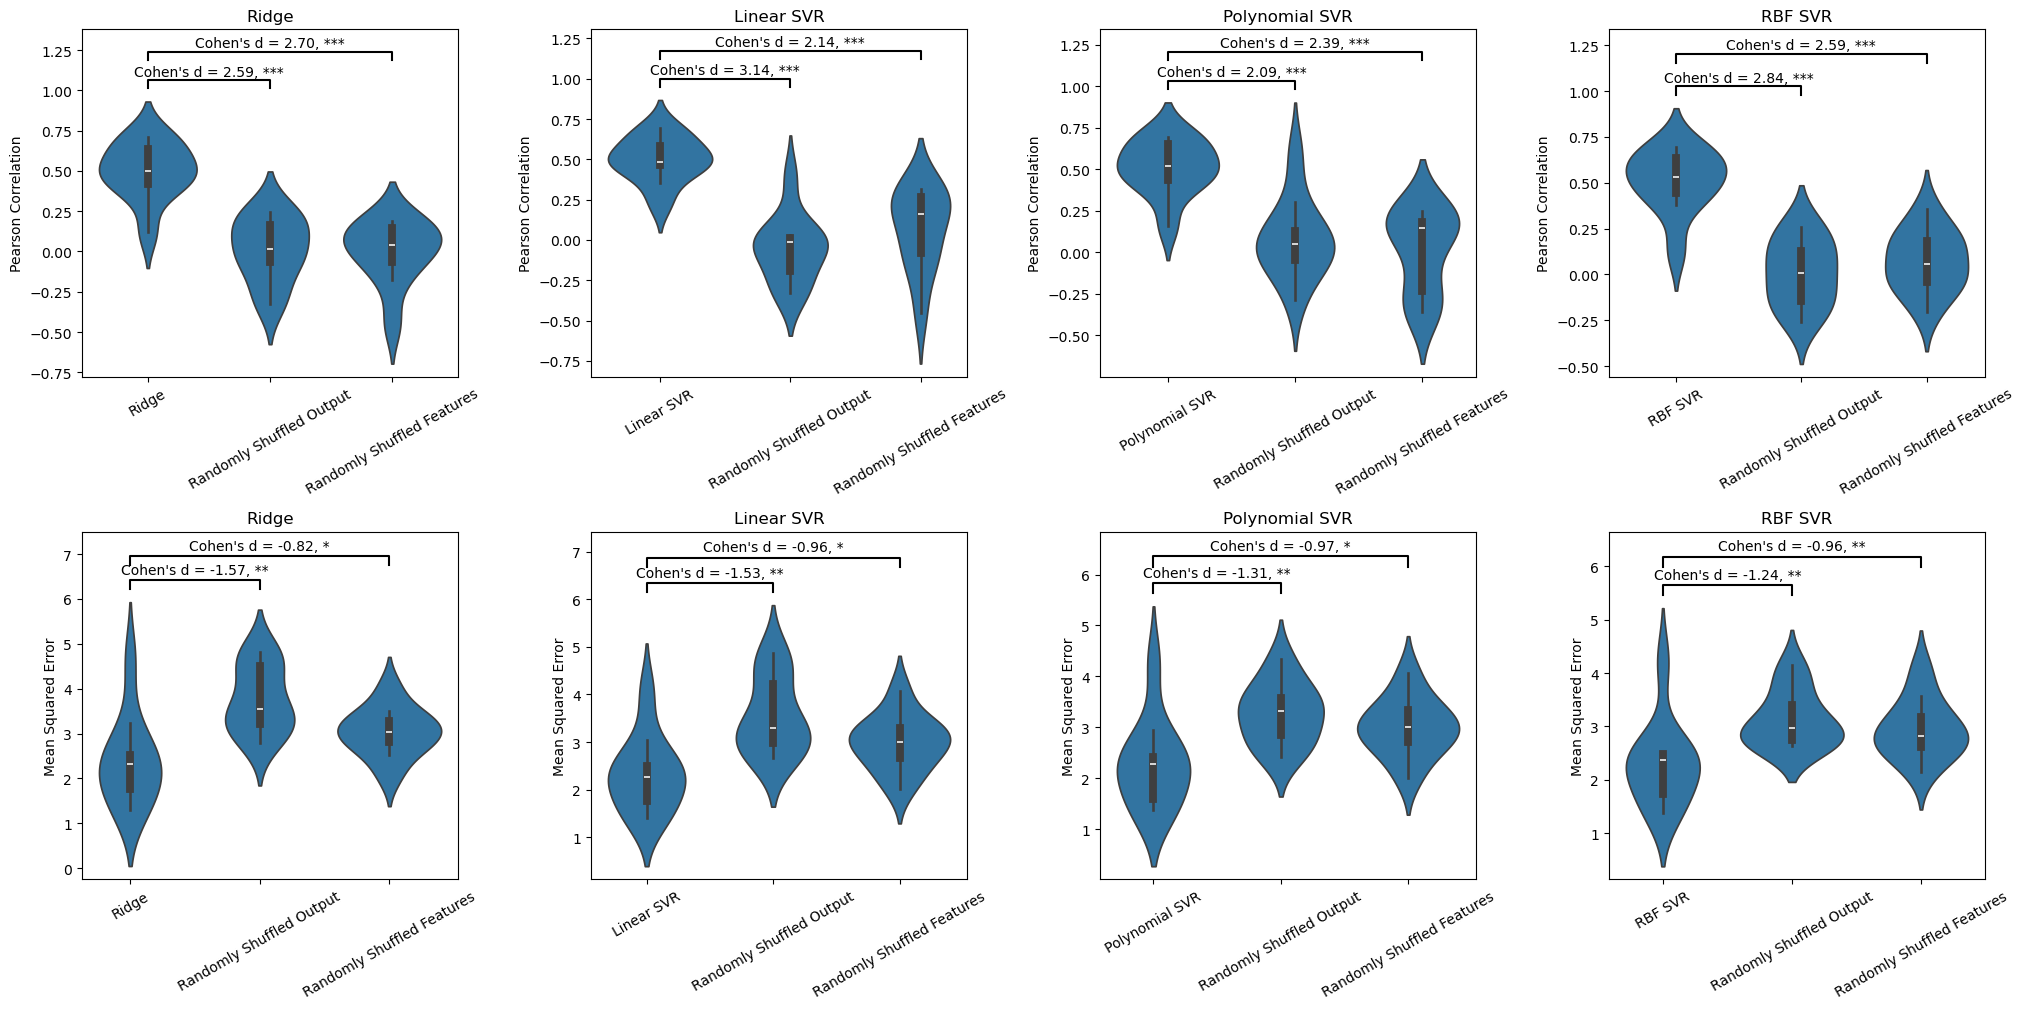

In [29]:
ncols = len(best_pipelines)
nrows = 2 # two metrics
fig, ax = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols*5.1, nrows*5.1))

for j, model_type in enumerate(best_pipelines.keys()):
#     break
    
    for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
        viz_df = viz_df_[[col for col in viz_df_ if model_type in col]]
        viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

        # some formatting
        viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type], 
                                  'random_y_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Output', 
                                 'random_X_test_' +mmap[metric_type] + '_' + model_type: 'Randomly Shuffled Features'})
        
        # may want to do this across all comparisons simultaneously
        res_stats, mod_combs = get_stats(viz_df, stat_type = 'random', model_type = model_type, metric_type = metric_type)

        sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i, j])
        ax[i, j].set_title(model_map[model_type])
        ax[i, j].set_xlabel('')
        
        xlabels = [x._text for x in ax[i, j].get_xticklabels()]
        ax[i, j].set_xticklabels(xlabels, 
                          rotation=30, 
                         ha = 'center')
        
        x_pos = dict(zip(xlabels, ax[i,j].get_xticks()))

        y_lower, y = ax[i,j].get_ylim()
        h = unit_map['h'][metric_type]
        
        # significance
        sig_counter = 0
        for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
            x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

            fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
            cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

            significance = "N.S."
            if fdr <= 1e-4:
                significance = "****"
            elif fdr <= 0.001:
                significance = "***"
            elif fdr <= 0.01:
                significance = "**"
            elif fdr <= 0.1:
                significance = "*"

            if significance != 'N.S.':
    #             y_pos = y+(sig_counter*0.15)
                y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
                ax[i,j].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                        [y_pos, y_pos+h, y_pos+h, y_pos], 
                        lw=1.5, c='black')
                y_pos*=unit_map['y_pos_scale'][metric_type]
                ax[i,j].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                        ha='center', va='bottom', fontsize=10)
                sig_counter += 1
        if sig_counter != 0:
            ax[i,j].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()
   

All models perform better than random.

### Assessment 2

Next, let's test whether there is a difference in model performance across the consensus models:

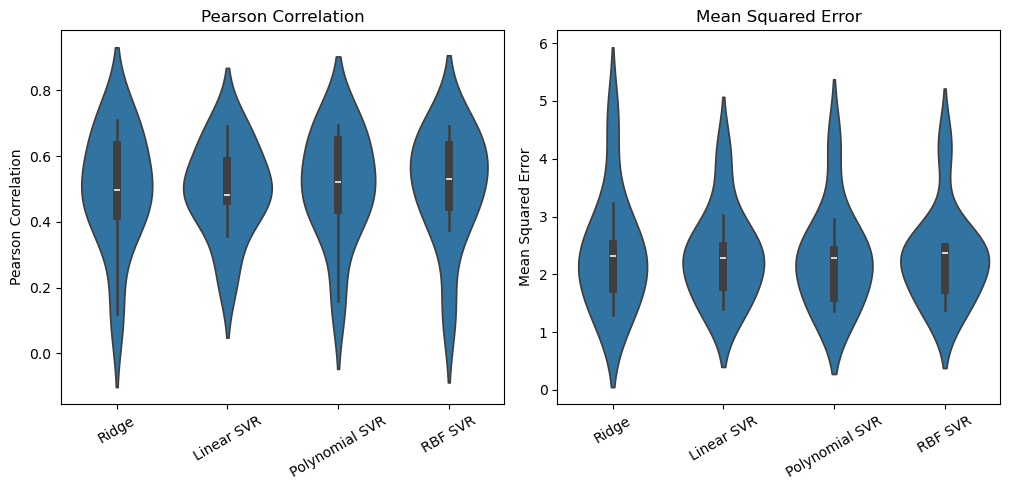

In [30]:
ncols = 2
fig, ax = plt.subplots(ncols = ncols, figsize = (ncols*5.1, 5))

for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
    viz_df = viz_df_[[col for col in viz_df_ if 'random' not in col]]
    viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type] for model_type in best_pipelines.keys()})

    # may want to do this across all comparisons simultaneously
    res_stats, mod_combs = get_stats(viz_df, stat_type = 'within', 
                                     model_type = None, 
                                     metric_type = None)

    sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i])
    ax[i].set_title(metric_type)
    ax[i].set_xlabel('')

    xlabels = [x._text for x in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(xlabels, 
                      rotation=30, 
                     ha = 'center')

    x_pos = dict(zip(xlabels, ax[i].get_xticks()))

    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric_type]

    # significance
    sig_counter = 0
    for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"

        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                    [y_pos, y_pos+h, y_pos+h, y_pos], 
                    lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric_type]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()




There is no significant difference in consensus model performance by either metric.

### Assessment 3

Finally, let's test whether there is a difference in these model performances vs the consensus model identified in transcriptomics. We use the consensus linear SVR as outlined in [this notebook](../A_rna_prediction/03_predict_transcriptomics.ipynb). 

We use the results from the power analysis [here](../A_rna_prediction/05_power_analysis_transcriptomics.ipynb), selecting the run with the number of samples equal to the number of samples available to proteomics. One caveat here is that the transcriptomic results were note calculated on the same set of folds as proteomics. However, given the bootstrapping of 100 subsets per fold, results should be consistent. 

In [28]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0).values
y = pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean'].values.ravel()


transcriptomics_power = pd.read_csv(os.path.join(data_path, 'processed', 'power_analysis_transcriptomics_linear_svr.csv'), index_col = 0)
transcriptomics_res = transcriptomics_power[transcriptomics_power.train_sample_size == y.shape[0]]


In [29]:
transcriptomics_res.test_corr.mean()

np.float64(0.4369363649065971)

In [30]:
transcriptomics_res.test_corr.median()

np.float64(0.43809238440330134)

In [31]:
transcriptomics_res.test_corr.std()

np.float64(0.0886290671760917)

In [32]:
transcriptomics_res.test_mse.std()

np.float64(0.42617669829642263)

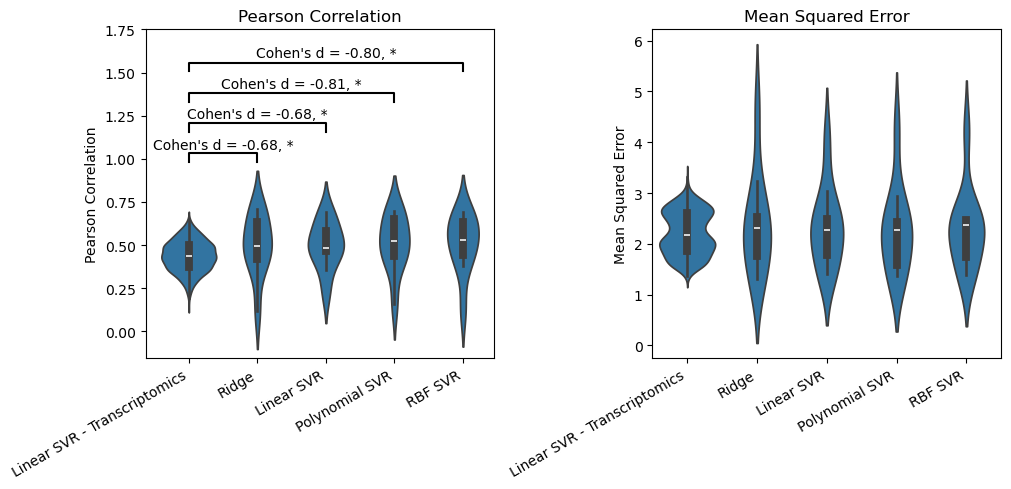

In [33]:
ncols = 2
fig, ax = plt.subplots(ncols = ncols, figsize = (ncols*5.1, 5))

for i, (metric_type, viz_df_) in enumerate(viz_dfs.items()):
    viz_df = viz_df_[[col for col in viz_df_ if 'random' not in col]]
    viz_df = pd.melt(viz_df, value_name=metric_type, var_name = 'Model Type')

    # some formatting
    viz_df['Model Type'] = viz_df['Model Type'].map({'test_' +mmap[metric_type] + '_' + model_type: model_map[model_type] for model_type in best_pipelines.keys()})

    viz_df_rna = pd.DataFrame(data = {'Model Type': 'Linear SVR - Transcriptomics', 
                                      metric_type: transcriptomics_res['test_' + mmap[metric_type]]}
                             ).reset_index(drop = True)
    viz_df = pd.concat([viz_df_rna, viz_df], axis = 0)
    
    res_stats, mod_combs = get_stats(viz_df, stat_type = 'transcriptomics', 
                                     model_type = None, 
                                     metric_type = None)

    sns.violinplot(data = viz_df, x = 'Model Type', y = metric_type, ax = ax[i])
    ax[i].set_title(metric_type)
    ax[i].set_xlabel('')

    xlabels = [x._text for x in ax[i].get_xticklabels()]
    ax[i].set_xticklabels(xlabels, 
                      rotation=30, 
                     ha = 'right')

    x_pos = dict(zip(xlabels, ax[i].get_xticks()))

    y_lower, y = ax[i].get_ylim()
    h = unit_map['h'][metric_type]

    # significance
    sig_counter = 0
    for k, (comp1, comp2) in enumerate(mod_combs):#(itertools.combinations(xlabels, 2)):
        x_mid = (x_pos[comp1] + x_pos[comp2]) / 2

        fdr = res_stats[res_stats.comparison == (comp1, comp2)]['fdr'].values[0]
        cd = res_stats[res_stats.comparison == (comp1, comp2)]['cohen_d'].values[0]

        significance = "N.S."
        if fdr <= 1e-4:
            significance = "****"
        elif fdr <= 0.001:
            significance = "***"
        elif fdr <= 0.01:
            significance = "**"
        elif fdr <= 0.1:
            significance = "*"

        if significance != 'N.S.':
#             y_pos = y+(sig_counter*0.15)
            y_pos = y+(sig_counter*unit_map['y_pos_scale_0'][metric_type])
            ax[i].plot([x_pos[comp1], x_pos[comp1], x_pos[comp2], x_pos[comp2]], 
                    [y_pos, y_pos+h, y_pos+h, y_pos], 
                    lw=1.5, c='black')
            y_pos*=unit_map['y_pos_scale'][metric_type]
            ax[i].text(x_mid, y_pos + h, f"Cohen's d = {cd:.2f}, " + significance, 
                    ha='center', va='bottom', fontsize=10)
            sig_counter += 1
    if sig_counter != 0:
        ax[i].set_ylim(y_lower, y_pos*unit_map['y_max_scale'][metric_type])
fig.tight_layout()


There is no difference in model performance by MSE. However, the transcriptomics only consensus model performs worse than all the consensus joint models as measured by Pearson correlation. Altgoether, this indicates that the combined consideration of transcriptomics of proteomics enhances model predictive power as compared to considering transcriptomics alone. 

Quantitatively, while the transcriptomics only linear SVR achieved a mean Pearson correlation of 0.43 at the sample size of 247, the joint transcriptomics + proteomics model achieved a mean Pearson correlation between 0.50-0.51 for the consensus models. That's approximately 6 percentage points more variance explained (R^2 of 0.191 vs ~0.25 respectively).

Since there is no significant difference in consensus model performances between model types within the joint omics, and since the linear SVR demonstrated the smallest standard deviation across folds and is consistent with the consensus model selected for transcriptomics, we will proceed with this model.